In [1]:
%%capture
%run preprocessing.ipynb

In [2]:
# Affiche les variables et modules importés depuis le notebook preprocessing.ipynb
%whos

Variable   Type         Data/Info
---------------------------------
flipkart   DataFrame                             <...>\n[1050 rows x 4 columns]
gc         module       <module 'gc' (built-in)>
msno       module       <module 'missingno' from <...>\missingno\\__init__.py'>
os         module       <module 'os' (frozen)>
pd         module       <module 'pandas' from 'c:<...>es\\pandas\\__init__.py'>
plt        module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>


In [3]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions as efficientnet_decode_predictions

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [4]:
image_df = globals()['flipkart']
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


**INITIALISE LE MODELE AVEC TOUTES LES LAYERS SANS AUCUN POIDS + CHANGEMENT DE LA COUCHE DE SORTIE A 7 CLASSES**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [6]:
n_classes = image_df['class'].nunique()

**SCENARIO 1 - Entraîner le modèle sans les poinds pré-entrainés sur 'imagenet'**

In [7]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

In [8]:
# Affiche les couches de sortie du modèle
model.layers[-3:]

[<GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dropout name=top_dropout, built=True>,
 <Dense name=predictions, built=True>]

In [18]:
def compile_and_fit(model, N_EPOCHS, LEARNING_RATE, data_augmentation_params=None):
    if data_augmentation_params is not None:
        datagen = ImageDataGenerator(
            preprocessing_function=efficientnet_preprocess_input,
            validation_split=0.2,
            **data_augmentation_params
        )
    else:
        datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input,
        validation_split=0.2
        )

    train_generator = datagen.flow_from_dataframe(
        dataframe=image_df,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=image_df,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Compile le modèle
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entraîne le modèle
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=N_EPOCHS
    )

    # Retourne l'historique de l'entraînement
    return history

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.1902 - loss: 1.9886 - val_accuracy: 0.1190 - val_loss: 2.2641
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.1766 - loss: 1.9612 - val_accuracy: 0.1143 - val_loss: 2.2193
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.2289 - loss: 1.9027 - val_accuracy: 0.0810 - val_loss: 2.2055
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.2605 - loss: 1.8370 - val_accuracy: 0.1286 - val_loss: 2.1556
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.2976 - loss: 1.8164 - val_accuracy: 0.1286 - val_loss: 2.1607
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.3452 - loss: 1.7732 - val_accuracy: 0.1619 - val_loss: 2.2265
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.4173 - loss: 1.5805 - val_accuracy: 0.1619 - val_loss: 2.1425
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.4460 - loss: 1.5619 - val_accuracy: 0.1667 - val_loss: 2.

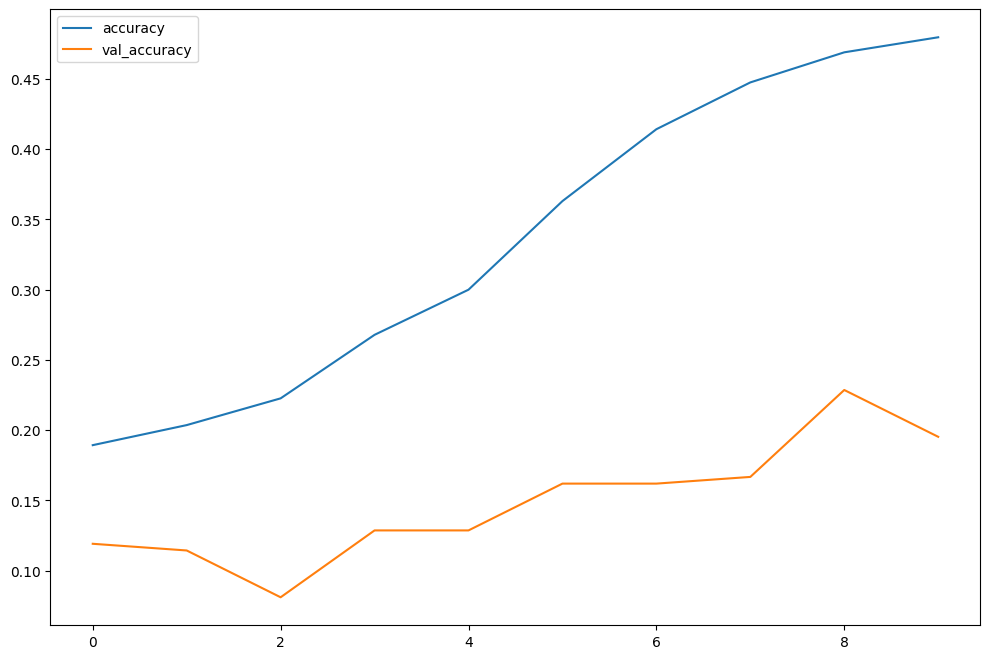

In [14]:
LEARNING_RATE = 1e-3
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [15]:
# SCENARIO 2 : On utilise les poids pré-entraînés sur ImageNet ET on reproduit les dernières couches de l'output du modèle
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_240>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_477>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3662 - loss: 1.9624 - val_accuracy: 0.5429 - val_loss: 1.3141
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7848 - loss: 0.6843 - val_accuracy: 0.6857 - val_loss: 1.0992
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.8521 - loss: 0.4516 - val_accuracy: 0.7333 - val_loss: 1.0091
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 957ms/step - accuracy: 0.8903 - loss: 0.3830 - val_accuracy: 0.7000 - val_loss: 0.9799
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8981 - loss: 0.3289 - val_accuracy: 0.6857 - val_loss: 0.9375
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9334 - loss: 0.2318 - val_accuracy: 0.7762 - val_loss: 0.8098
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9116 - loss: 0.2368 - val_accuracy: 0.7857 - val_loss: 0.8062
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9389 - loss: 0.2254 - val_accuracy: 0.7619 - val_loss: 0.83

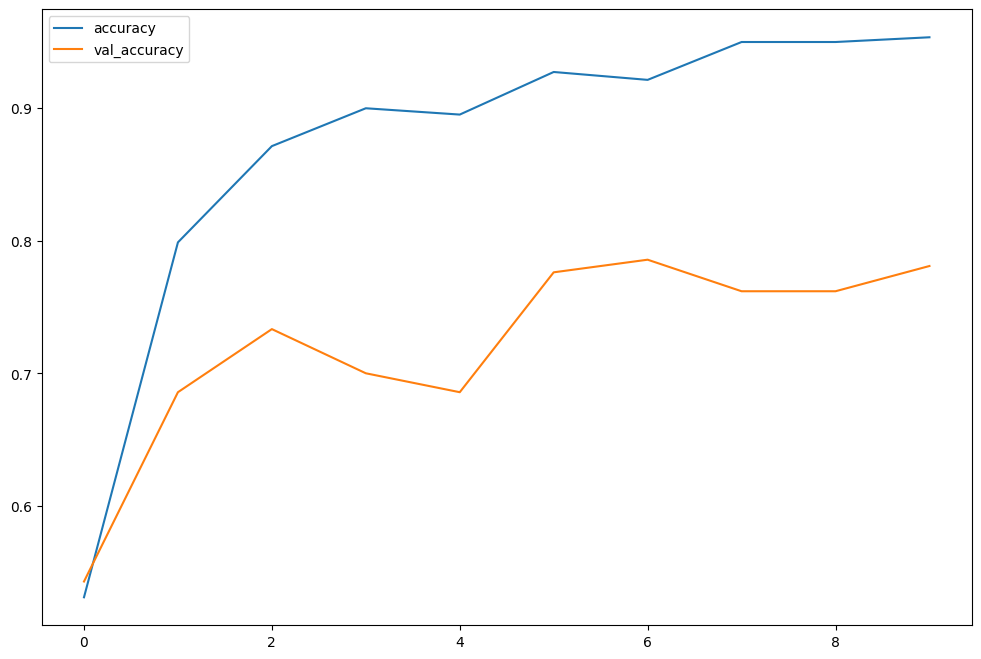

In [16]:
LEARNING_RATE = 1e-3
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [21]:
# SCENARIO 3 : Même modèle que le SCENARIO 2 mais on dégèle les dernières couches du modèle
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Unfreeze les 10 dernières couches du modèle exceptés les couches BatchNormalization
for layer in model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_724>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_961>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/27 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.1796 - loss: 2.7805

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.2518 - loss: 2.4322 - val_accuracy: 0.4333 - val_loss: 1.5363
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.6628 - loss: 0.9977 - val_accuracy: 0.5952 - val_loss: 1.3102
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.8189 - loss: 0.5819 - val_accuracy: 0.6048 - val_loss: 1.1954
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9030 - loss: 0.3352 - val_accuracy: 0.6476 - val_loss: 1.1053
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9154 - loss: 0.2693 - val_accuracy: 0.6714 - val_loss: 1.0490
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9262 - loss: 0.2420 - val_accuracy: 0.6905 - val_loss: 1.0030
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.9541 - loss: 0.1899 - val_accuracy: 0.6905 - val_loss: 0.9562
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.9695 - loss: 0.1245 - val_accuracy: 0.7048 - val_loss: 0.

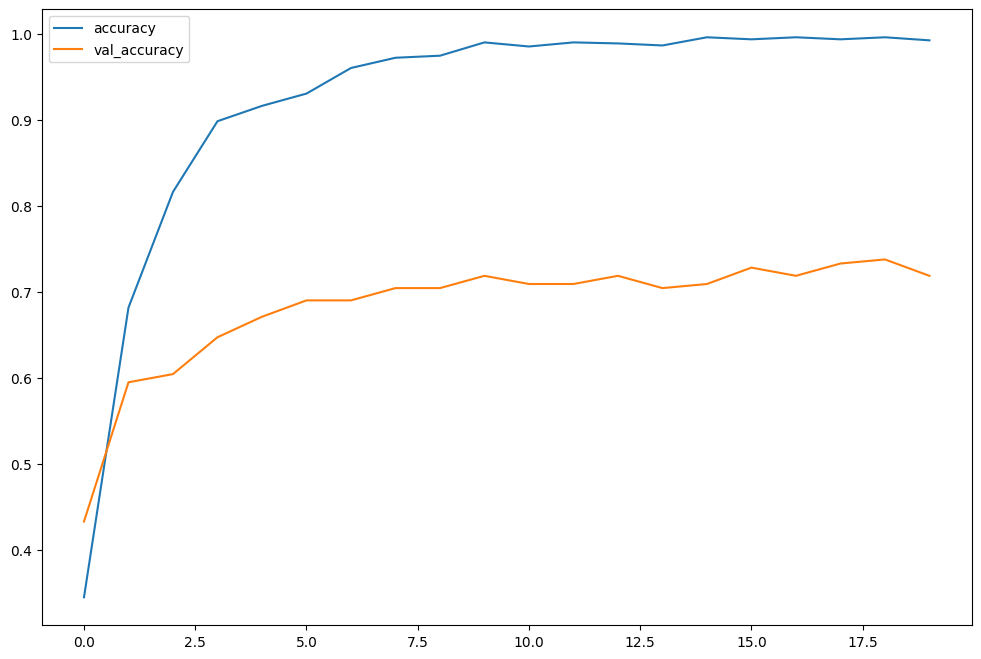

In [22]:
LEARNING_RATE = 1e-4
N_EPOCHS = 20

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
# SCÉNARIO 4 : On utilise le même modèle que le SCENARIO 3 mais on rajoute de la data augmentation
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Unfreeze les 10 dernières couches du modèle exceptés les couches BatchNormalization
for layer in model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_966>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1203>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.1983 - loss: 2.5630 - val_accuracy: 0.3857 - val_loss: 1.6526
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.6268 - loss: 1.0760 - val_accuracy: 0.5000 - val_loss: 1.4359
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.7062 - loss: 0.8688 - val_accuracy: 0.6143 - val_loss: 1.2484
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.7699 - loss: 0.6775 - val_accuracy: 0.6619 - val_loss: 1.0858
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.8229 - loss: 0.5492 - val_accuracy: 0.6619 - val_loss: 1.0201
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.8624 - loss: 0.3969 - val_accuracy: 0.7333 - val_loss: 0.9558
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.8866 - loss: 0.3499 - val_accuracy: 0.7000 - val_loss: 0.9166
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8874 - loss: 0.3175 - val_accuracy: 0.7381 - val_loss: 0.

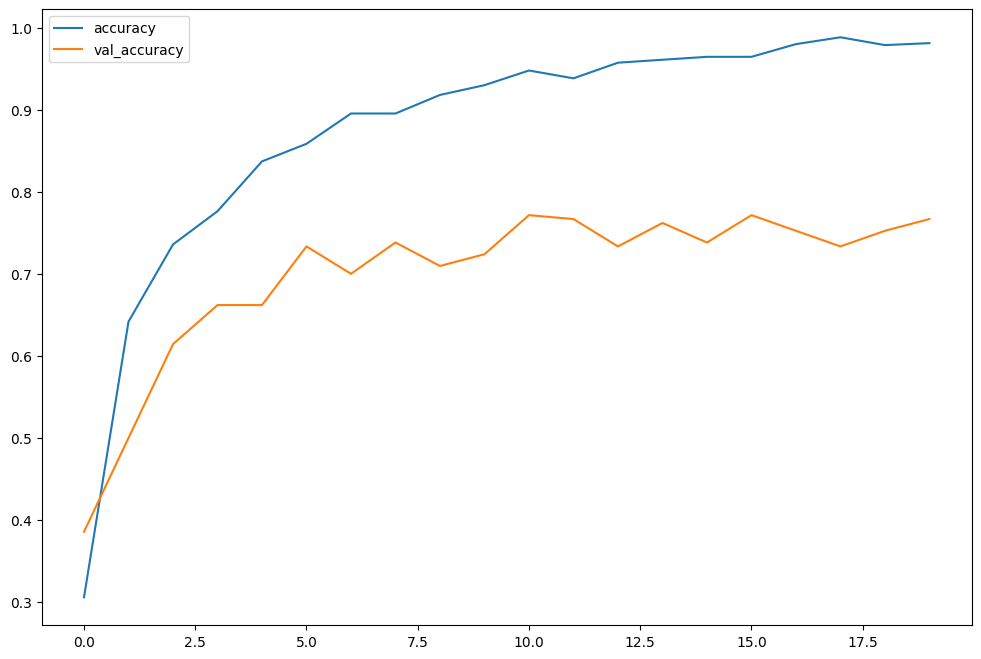

In [25]:
N_EPOCHS = 20
LEARNING_RATE = 1e-4
data_augmentation_params = {
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'shear_range': 0.15,
    'zoom_range': 0.15,
    'horizontal_flip': True,
    'vertical_flip': True
}

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, data_augmentation_params)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [26]:
# SCÉNARIO 5 : On utilise le même modèle que dans le scénario 2 avec la data augmentation et plus d'EPOCH 
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1208>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1445>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/27 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2264 - loss: 2.2212

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3790 - loss: 1.8084 - val_accuracy: 0.5714 - val_loss: 1.3245
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7236 - loss: 0.8898 - val_accuracy: 0.6810 - val_loss: 1.1230
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7964 - loss: 0.6911 - val_accuracy: 0.6810 - val_loss: 1.0248
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8391 - loss: 0.4786 - val_accuracy: 0.6714 - val_loss: 0.9960
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8412 - loss: 0.4209 - val_accuracy: 0.7190 - val_loss: 0.8820
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8529 - loss: 0.4287 - val_accuracy: 0.6619 - val_loss: 0.9361
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8854 - loss: 0.3434 - val_accuracy: 0.7333 - val_loss: 0.8221
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8745 - loss: 0.3458 - val_accuracy: 0.7429 - val_loss: 0.8196
Epo

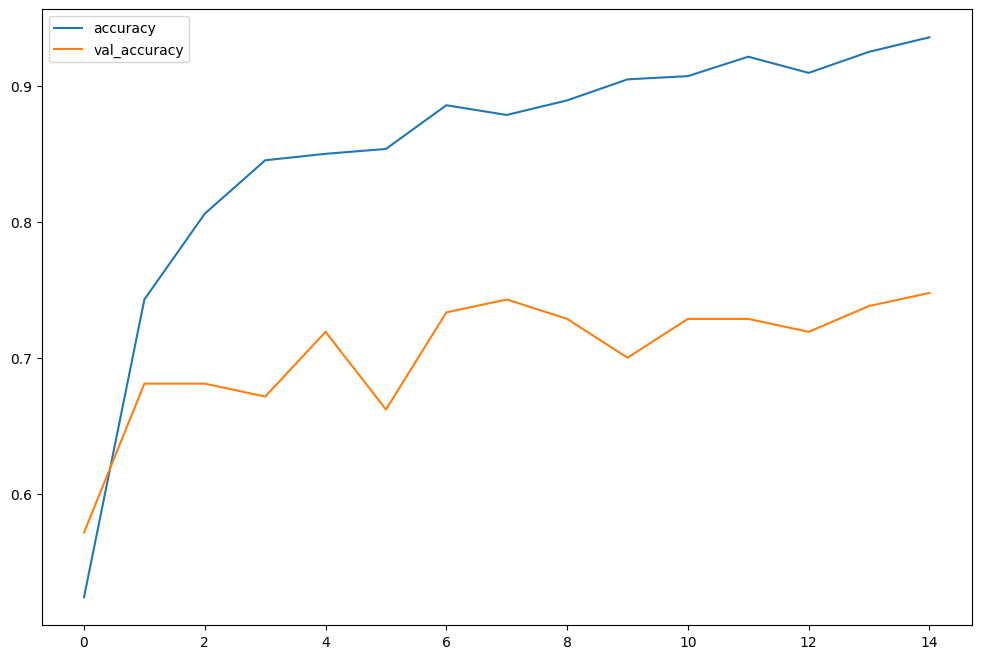

In [27]:
N_EPOCHS = 15
LEARNING_RATE = 1e-3
data_augmentation_params = {
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'shear_range': 0.15,
    'zoom_range': 0.15,
    'horizontal_flip': True,
    'vertical_flip': True
}

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, data_augmentation_params)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [28]:
# SCENARIO 6 : On utilise les poids pré-entraînés sur ImageNet avec des couches de sortie différentes
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1450>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1687>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/27 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3585 - loss: 1.8109

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5463 - loss: 1.5915 - val_accuracy: 0.4619 - val_loss: 1.3437
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8512 - loss: 0.6843 - val_accuracy: 0.7810 - val_loss: 0.8415
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8822 - loss: 0.4280 - val_accuracy: 0.8048 - val_loss: 0.7436
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9251 - loss: 0.2945 - val_accuracy: 0.8095 - val_loss: 0.6715
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9557 - loss: 0.2209 - val_accuracy: 0.8476 - val_loss: 0.6025
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9684 - loss: 0.1442 - val_accuracy: 0.8238 - val_loss: 0.6172
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9745 - loss: 0.1372 - val_accuracy: 0.8476 - val_loss: 0.5743
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9802 - loss: 0.0994 - val_accuracy: 0.8286 - val_loss: 0.5967
Epo

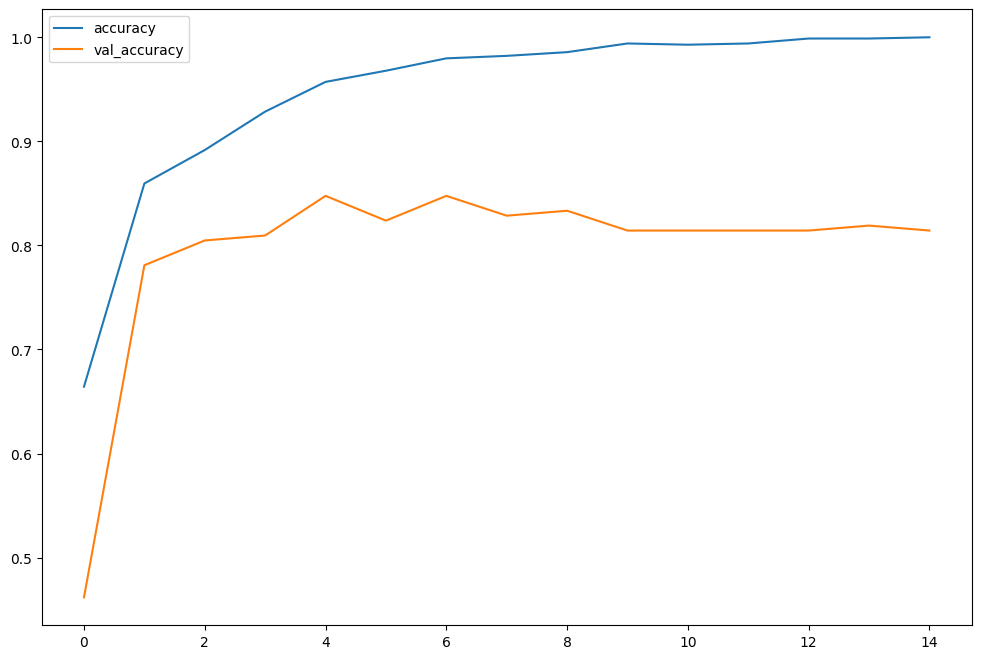

In [29]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [30]:
# SCENARIO 6 : On utilise les poids pré-entraînés sur ImageNet avec une couche dense supplémentaire et plus d'netraînement de couches
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1692>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1929>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5854 - loss: 1.1808 - val_accuracy: 0.7571 - val_loss: 0.7962
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4740s 3s/step - accuracy: 0.8652 - loss: 0.3951 - val_accuracy: 0.7714 - val_loss: 0.7020
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9414 - loss: 0.2017 - val_accuracy: 0.7000 - val_loss: 1.2384
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9408 - loss: 0.1854 - val_accuracy: 0.7286 - val_loss: 0.9842
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9617 - loss: 0.1333 - val_accuracy: 0.7476 - val_loss: 0.9665
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9748 - loss: 0.0941 - val_accuracy: 0.7619 - val_loss: 0.8983
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9728 - loss: 0.0890 - val_accuracy: 0.7429 - val_loss: 1.1200
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9889 - loss: 0.0490 - val_accuracy: 0.7238 - val_loss: 1.2300
E

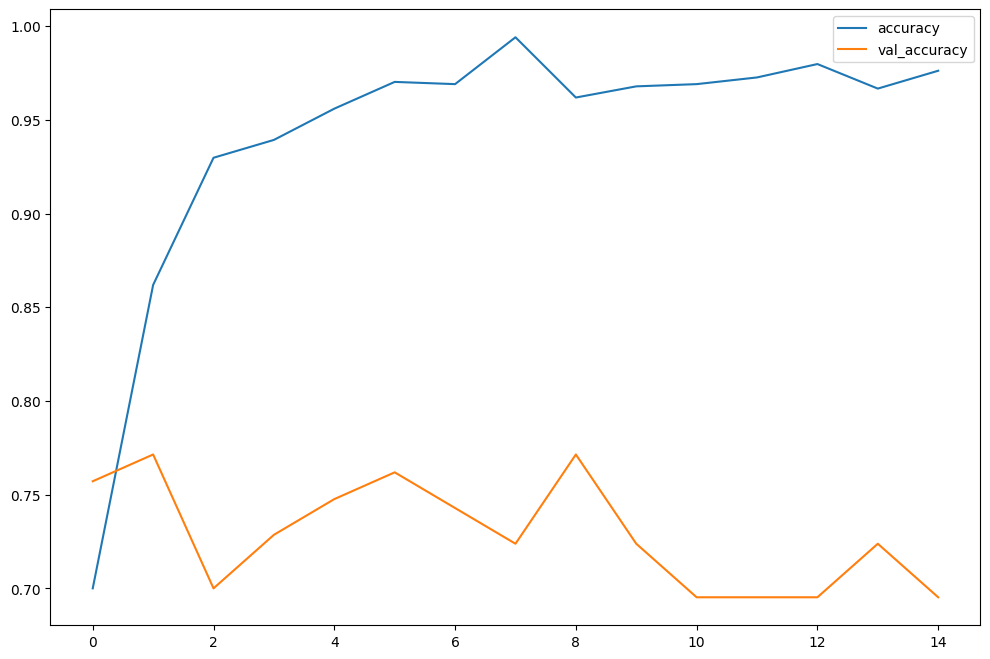

In [31]:
# Crée un datagen avec des paramètres d'optimisation différents
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.25,
    shear_range=0.25,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()